# Run "Classic" pandas version of processing with Numpyro Baysian method

In [24]:
import pandas as pd
#import MarineDNA as md
import plotly.express as px
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import itertools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import the data

In [31]:
file1 = "../Data/merged_data/no_duplicates/Merged2018_16S_otu_filtered.csv"
file2 = "../Data/merged_data/no_duplicates/Merged2018_18S_otu_filtered.csv"
asvs_16S = pd.read_csv(file1, index_col=0)
asvs_18S = pd.read_csv(file2, index_col=0)
'''
print('Number of 16S ASVs:', len(asvs_16S))
print('Number of 16S samples:', len(list(asvs_16S)))
print('Number of 18S ASVs:', len(asvs_18S))
print('Number of 18S samples:', len(list(asvs_18S)))
'''

"\nprint('Number of 16S ASVs:', len(asvs_16S))\nprint('Number of 16S samples:', len(list(asvs_16S)))\nprint('Number of 18S ASVs:', len(asvs_18S))\nprint('Number of 18S samples:', len(list(asvs_18S)))\n"

In [41]:
# get lists of sample and asv names
labels_samples_16S = list(asvs_16S)
labels_samples_18S = list(asvs_18S)
labels_asvs_16S = asvs_16S.index.tolist()
labels_asvs_18S = asvs_18S.index.tolist()

print('Number of 16S ASVs:', len(labels_asvs_16S))
print('Number of 16S samples:', len(labels_samples_16S))
print('Number of 18S ASVs:', len(labels_asvs_18S))
print('Number of 18S samples:', len(labels_samples_18S))

Number of 16S ASVs: 7077
Number of 16S samples: 131
Number of 18S ASVs: 10475
Number of 18S samples: 131


## Functions

In [42]:
# Return data frame of a draw of relative percent of occurrence from a beta distribution
# fit to observed occurrence counts
#   df: data frame where rows = ASVs and columns = samples
def ranRelPct(df, asLogOdds = True):
    import pandas as pd
    import numpy as np
    
    def betaCol(col):
        beta_dist = np.random.beta(col + 1, col.sum() - col + 1)
        return beta_dist / beta_dist.sum()
    result = np.empty([df.shape[0], df.shape[1]])
    for i in range(result.shape[1]):
        result[:,i] = betaCol(df.iloc[:,i])
    if asLogOdds:
        result = np.log(result / (1 - result))
    return pd.DataFrame(result, index = df.index, columns = df.columns).transpose()

In [43]:
# Does hierarchical clustering on data frame where rows are samples and columns are ASVs
# Returns array of cluster labels for rows
def doClustering(df, num_clusts, num_pcs = None):
    from sklearn.cluster import AgglomerativeClustering
    
    agg_clust = AgglomerativeClustering(n_clusters = num_clusts, metric = "euclidean", linkage = "ward")
    labels = agg_clust.fit_predict(df)
    return labels.astype(str)

In [44]:
def pctSame(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        unique, counts = np.unique(row, return_counts=True)
        return max(counts)
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    *pws_rows, = itertools.combinations(range(cluster_samples.shape[0]), 2)
    pws_same = np.empty([len(pws_rows), n_rep])
    for c in range(pws_same.shape[1]):
        for r in range(pws_same.shape[0]):
            pws_same[r, c] = cluster_samples.iloc[pws_rows[r][0], c] == cluster_samples.iloc[pws_rows[r][1], c]
    
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])

In [45]:
# Does PCA
#   df: data frame where rows = samples and columns = ASVs
#   num_pcs: number of components to return. if None, return maximum number
# Returns a dictionary containing :
#   scores: array of PCA scores
#   loadings: array of PCA loadings
def doPCA(df, num_pcs = None):
    import numpy as np
    from sklearn.decomposition import PCA
    
    max_pcs = min(df.shape[0] - 1, df.shape[1] - 1)
    if num_pcs is None:
        num_pcs = max_pcs
    elif num_pcs > max_pcs:
        num_pcs = max_pcs
    pca = PCA(n_components = num_pcs)
    pca_fit = pca.fit(df)
    pca_results = {
        "scores": pca_fit.transform(df),
        "loadings": np.transpose(pca_fit.components_),
        "explained_variance": pca.explained_variance_ratio_
        # add line exported explained variance
    }
    return pca_results

## One draw

In [61]:
# one random draw
ran_lo_16S = ranRelPct(asvs_16S)
ran_lo_18S = ranRelPct(asvs_18S)
# one PCA
pca_results_16S = doPCA(ran_lo_16S,num_pcs =6)
pca_results_18S = doPCA(ran_lo_18S,num_pcs =6)

In [72]:
# Format PCA results:
#16S
df = pd.DataFrame(pca_results_16S["scores"], index=labels_samples_16S)
df.columns = '16S_PC'+(df.columns + 1).astype(str)
pca_scores_16S = df.copy()

#18S
df = pd.DataFrame(pca_results_18S["scores"], index=labels_samples_18S)
df.columns = '18S_PC'+(df.columns + 1).astype(str)
pca_scores_18S = df.copy()
df.head()

18S_PC1    18S_PC2    18S_PC3   18S_PC4   18S_PC5  \
CN18FESPkoa_SC24 -27.437725  56.619744 -24.441036 -3.058991 -5.045326   
CN18Fc21_6_eDNA   35.513909  52.585888 -25.917480 -3.979306  2.845634   
CN18Fc22_6_eDNA   30.094954  56.956841 -25.878744 -5.098666  2.324765   
CN18Fc24_6_eDNA    6.080527  56.841557 -27.589100  1.175295 -0.524946   
CN18Fc25_5_eDNA   22.540221  33.949633 -13.348690  5.118792 -7.637588   

                    18S_PC6  
CN18FESPkoa_SC24 -15.465933  
CN18Fc21_6_eDNA    8.545140  
CN18Fc22_6_eDNA    9.943539  
CN18Fc24_6_eDNA    6.646613  
CN18Fc25_5_eDNA    8.291828

# NumPyro

In [117]:
# need torch ?
# import jax
# jax.__version__


In [108]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

# assert numpyro.__version__.startswith("0.11.0")

In [109]:
# Make dataframe of first 6 16S PC scores and first 2 18S PC scores
df = pd.concat([pca_scores_16S.iloc[:,:7], pca_scores_18S.iloc[:,:2]], axis=1)
comb_scores = df.copy()
comb_scores.head()

16S_PC1   16S_PC2    16S_PC3   16S_PC4   16S_PC5  \
CN18Fc43_5_eDNA  -57.741773  1.742896  14.559429 -3.048323 -0.425315   
CN18FESPkoa_SC58 -57.393066 -0.836855  12.488872 -5.012920 -0.715211   
CN18FESPkoa_SC43 -60.519959  3.758491   5.976682 -3.741416 -2.177288   
CN18FESPkoa_SC40 -64.811185  1.026923   1.270246 -7.224471  1.320278   
CN18FESPkoa_SC37 -12.184514 -2.182209  47.952847  2.744739 -2.871406   

                   16S_PC6    18S_PC1    18S_PC2  
CN18Fc43_5_eDNA  -3.246854  45.864246  51.689209  
CN18FESPkoa_SC58 -3.903628  46.020918  51.785979  
CN18FESPkoa_SC43 -3.460987  19.233558  63.033573  
CN18FESPkoa_SC40 -4.150055  -8.910455  60.696889  
CN18FESPkoa_SC37  0.827160  -1.784969  66.958484

In [110]:
# Prepare training data
# dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18', 'pc2_values_18'
#                          ]]
dataset_HA2 = comb_scores.copy()
#train = torch.tensor(dataset_HA2.values, dtype=torch.float).cuda
train = dataset_HA2.copy()


In [118]:
def model(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18_obs=None):
    a = numpyro.sample("PC1_a", dist.Normal(0., 10.))
    b_PC1 = numpyro.sample("PC1_b1", dist.Normal(0., 1.))
    b_PC2 = numpyro.sample("PC1_b2", dist.Normal(0., 1.))
    b_PC3 = numpyro.sample("PC1_b3", dist.Normal(0., 1.))
    b_PC4 = numpyro.sample("PC1_b4", dist.Normal(0., 1.))
    b_PC5 = numpyro.sample("PC1_b5", dist.Normal(0., 1.))
    b_PC6 = numpyro.sample("PC1_b6", dist.Normal(0., 1.))
    sigma = numpyro.sample("PC1_sigma", dist.Uniform(0., 10.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with numpyro.plate("data", len(pc6_values_16)):
        return pyro.sample("PC1_obs", dist.Normal(mean, sigma), obs=pc1_values_18_obs)
 

In [119]:
from sklearn.preprocessing import LabelEncoder
pc1_values_18_encoder = LabelEncoder()
train["18S_PC1"] = pc1_values_18_encoder.fit_transform(dataset_HA2['18S_PC1'].values)

pc1_values_16 =  dataset_HA2['16S_PC1'].values
pc2_values_16 =  dataset_HA2['16S_PC2'].values
pc3_values_16 =  dataset_HA2['16S_PC3'].values
pc4_values_16 =  dataset_HA2['16S_PC4'].values
pc5_values_16 =  dataset_HA2['16S_PC5'].values
pc6_values_16 =  dataset_HA2['16S_PC6'].values
pc1_values_18 = train["18S_PC1"].values

In [120]:

nuts_kernel = NUTS(model)

# mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000
#             #num_chains=2
#            ) #this implements num_chains

#mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000) #this implements num_chains
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=2) #this implements num_chains

rng_key = random.PRNGKey(0)
mcmc.run(rng_key,pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16,  pc1_values_18_obs=pc1_values_18)

posterior_samples = mcmc.get_samples()


/tmp/ipykernel_82/1423306038.py:8: UserWarning:

There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

2023-03-02 20:25:31.754790: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-02 20:25:31.756157: E external/org_tensorflow/tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:627) dnn != nullptr 
*** Begin stack trace ***
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	_PyObject_MakeTpCall
	
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	
	_PyEval_EvalFrameDefault
	
	_P

XlaRuntimeError: INTERNAL: RET_CHECK failure (external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:627) dnn != nullptr 

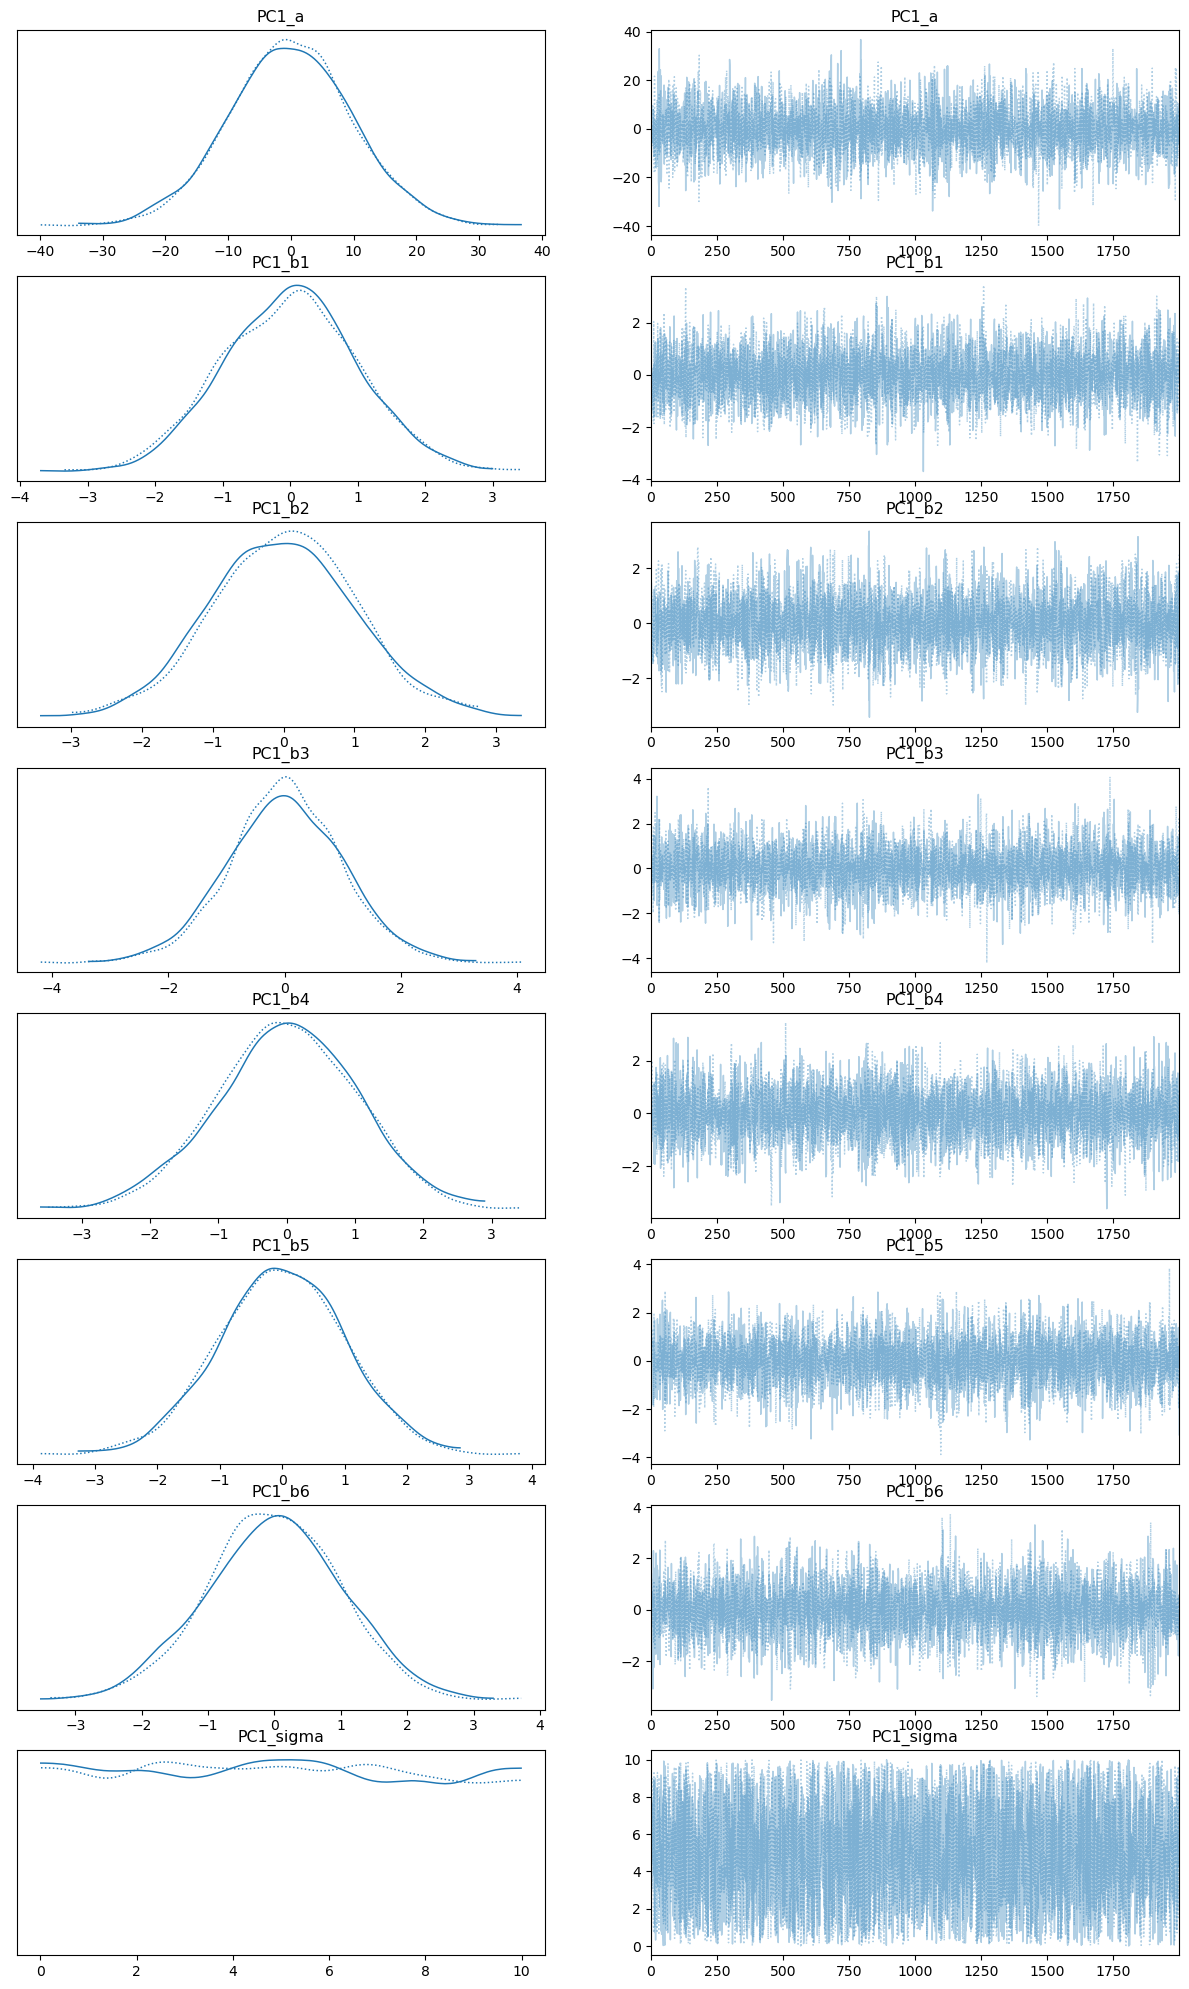

In [94]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));


# SCRAP BELOW

In [47]:
'''
# one cluster
n_rep = 10
#num_clust_16S = np.arange(2, asvs_16S.shape[1] +1)
num_clust_16S = np.arange(2, 20)
pct_same_16S = [pctSame(ran_lo_16S, x, n_rep) for x in num_clust_16S]
pct_same_16S
'''

'\n# one cluster\nn_rep = 10\n#num_clust_16S = np.arange(2, asvs_16S.shape[1] +1)\nnum_clust_16S = np.arange(2, 20)\npct_same_16S = [pctSame(ran_lo_16S, x, n_rep) for x in num_clust_16S]\npct_same_16S\n'

In [48]:
'''
# Plot percent of draws the same for each number of clusters
px.line(x = num_clust_16S, y = pct_same_16S)
'''

'\n# Plot percent of draws the same for each number of clusters\npx.line(x = num_clust_16S, y = pct_same_16S)\n'

### Perform one random draw

In [11]:
# one random draw
ran_lo_16S = md.ranRelPct(asvs_16S)
ran_lo_18S = md.ranRelPct(asvs_18S)
ran_lo_16S

ASV_1      ASV_2     ASV_3     ASV_4     ASV_5     ASV_6  \
CN18Fc43_5_eDNA  -3.160408  -1.960331 -3.357717 -7.262770 -5.150140 -4.353729   
CN18FESPkoa_SC58 -3.082412  -1.989434 -3.555958 -6.866430 -4.959835 -4.208698   
CN18FESPkoa_SC43 -3.155180  -1.840201 -3.335809 -6.743764 -4.919298 -4.129176   
CN18FESPkoa_SC40 -3.086268  -1.877294 -3.211244 -6.584872 -4.945289 -4.142107   
CN18FESPkoa_SC37 -3.118809  -2.195490 -3.667004 -7.113052 -4.914172 -4.313828   
...                    ...        ...       ...       ...       ...       ...   
Lasker18Sc145_19 -6.691308 -12.667689 -6.583835 -2.666197 -3.930845 -5.370975   
Lasker18Sc145_3  -1.386704  -6.473484 -3.115820 -5.151422 -5.754437 -3.882239   
Lasker18Sc145_5  -1.404011  -6.506269 -2.992316 -5.274994 -6.036312 -3.949698   
Lasker18Sc150_17 -6.226025 -13.745744 -4.568605 -1.615978 -2.827844 -3.792663   
Lasker18Sc135_17 -8.002759 -10.826377 -7.376445 -2.283109 -4.124373 -5.684536   

                     ASV_7     ASV_8      ASV_9    ASV_10  ...   ASV_8120  \
CN18Fc43_5_eDNA  -5.776124 -4.406628  -3.332231 -4.019428  ... -10.392766   
CN18FESPkoa_SC58 -5.848333 -4.593512  -2.867394 -4.227009  ... -12.238216   
CN18FESPkoa_SC43 -5.555428 -4.489784  -2.934557 -4.159521  ... -10.770925   
CN18FESPkoa_SC40 -5.540957 -4.305692  -3.263767 -4.257139  ... -10.817033   
CN18FESPkoa_SC37 -5.688286 -4.658746  -3.075251 -4.382130  ... -11.251807   
...                    ...       ...        ...       ...  ...        ...   
Lasker18Sc145_19 -3.538284 -6.071597 -10.313229 -6.536548  ... -11.495441   
Lasker18Sc145_3  -6.485737 -3.649913  -8.342362 -5.005208  ... -11.497973   
Lasker18Sc145_5  -5.834147 -3.532342 -10.886664 -4.833095  ... -10.638101   
Lasker18Sc150_17 -2.211485 -5.068006  -7.846791 -5.359874  ... -13.093985   
Lasker18Sc135_17 -4.829197 -9.565759 -10.047610 -7.342705  ... -10.502746   

                   ASV_8124   ASV_8125   ASV_8126   ASV_8127   ASV_8128  \
CN18Fc43_5_eDNA  -12.960620 -10.205757 -11.144099 -12.783366 -12.415274   
CN18FESPkoa_SC58 -10.801174 -12.741390 -14.768027 -11.238408 -10.934222   
CN18FESPkoa_SC43 -10.076169 -11.099887 -12.344340 -11.515667 -10.766421   
CN18FESPkoa_SC40 -13.076346 -11.128890 -11.496148 -10.544259 -14.810485   
CN18FESPkoa_SC37  -9.825510 -10.582508 -10.578292 -11.337221  -9.812544   
...                     ...        ...        ...        ...        ...   
Lasker18Sc145_19  -9.782443 -12.183839 -10.813525 -11.400556 -14.292478   
Lasker18Sc145_3  -10.749592 -11.620296 -12.978852 -11.768297 -12.135479   
Lasker18Sc145_5  -11.086957 -11.977285  -9.479996 -11.894497  -9.791620   
Lasker18Sc150_17 -12.494260  -9.802984 -12.600543 -11.098855 -10.662183   
Lasker18Sc135_17  -9.508507 -10.135838 -10.110304  -9.934318 -10.867651   

                   ASV_8129   ASV_8130   ASV_8132   ASV_8133  
CN18Fc43_5_eDNA  -18.374990 -13.763216 -12.041488 -11.138519  
CN18FESPkoa_SC58 -11.777615 -13.649738 -11.304832 -11.578492  
CN18FESPkoa_SC43 -13.055735 -11.024730 -10.636843 -10.811403  
CN18FESPkoa_SC40 -10.689578 -12.308131 -11.494242 -16.654696  
CN18FESPkoa_SC37 -11.772113 -11.697234  -9.926991 -12.034137  
...                     ...        ...        ...        ...  
Lasker18Sc145_19  -9.606006 -10.201087 -13.344280 -10.975008  
Lasker18Sc145_3  -10.268345 -11.328112 -10.625564 -12.728604  
Lasker18Sc145_5  -12.237949 -10.174571 -11.658773 -11.608583  
Lasker18Sc150_17 -10.983272 -10.526705 -12.237363 -11.250548  
Lasker18Sc135_17 -10.690908 -10.533644 -10.323301 -10.544720  

[131 rows x 7077 columns]

### Hierarchical clustering of random log-odds draw

In [12]:
labels_16S = md.doClustering(ran_lo_16S, 4)
labels_18S = md.doClustering(ran_lo_18S, 4)
print(labels_16S)
print()
print(pd.DataFrame(np.array(np.unique(labels_16S, return_counts=True)).T))

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '3' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '3' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '2' '2' '0' '2' '0' '0' '0' '0' '0' '0' '2' '2'
 '0' '2' '0' '3' '0' '0' '0' '0' '2' '0' '2' '0' '0' '2' '2' '0' '0' '2'
 '2' '0' '0' '2' '2' '0' '0' '2' '2' '2' '0' '0' '2' '2' '0' '2' '0' '2'
 '0' '0' '2' '0' '0' '2' '0' '0' '2' '2' '0' '0' '2' '2' '0' '2' '0' '2'
 '0' '0' '2' '2' '0' '2' '0' '2' '2' '0' '0' '2' '2' '0' '0' '2' '2' '2'
 '2' '0' '0' '2' '2']

   0   1
0  0  46
1  1  40
2  2  42
3  3   3


### Perform PCAs

In [13]:
pca_results_16S = md.doPCA(ran_lo_16S)
pca_results_18S = md.doPCA(ran_lo_18S)
pca_results_16S["scores"]

array([[-57.47501947,   2.83097306,  14.82799162, ...,  -7.66690684,
          4.14522991,  -3.99584683],
       [-55.14352124,  -2.79587389,  13.50371817, ..., -14.80956538,
         12.31703223,  -5.72837094],
       [-60.19079092,  -2.1825476 ,  10.00229758, ..., -20.37541205,
        -13.94308215,  -4.35451874],
       ...,
       [ 34.55438477,  18.3274588 ,   8.44884128, ...,   1.21952018,
          1.59046897,   0.51989065],
       [  4.64081651, -32.55382408, -44.69261226, ...,  -9.06466673,
         -6.51714378,   5.41577807],
       [ 36.04666096, -33.13028898,   1.76667184, ...,  -0.34907961,
          1.93659709,  -0.56520158]])

### Visualizing PCAs

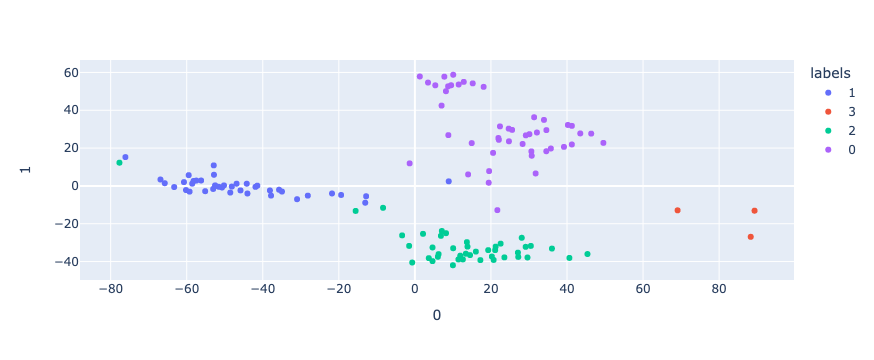

In [14]:
# 16S
scores_16S = pd.DataFrame(md.doPCA(ran_lo_16S)["scores"])
scores_16S["labels"] = labels_16S
fig_16S = px.scatter(
    scores_16S,
    x = 0,
    y = 1,
    color = "labels"
)
fig_16S.show()

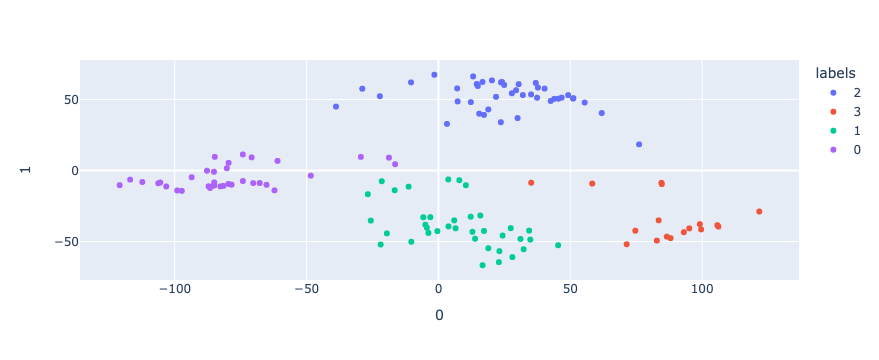

In [15]:
# 18S
scores_18S = pd.DataFrame(md.doPCA(ran_lo_18S)["scores"])
scores_18S["labels"] = labels_18S
fig_18S = px.scatter(
    scores_18S,
    x = 0,
    y = 1,
    color = "labels"
)
fig_18S.show()

### Cluster samples based on n_rep random draws and n_clust clusters

In [16]:
# 16S
n_clust = 8
n_rep = 10
 
cluster_samples_16S = [md.doClustering(md.ranRelPct(asvs_16S), n_clust) for i in range(n_rep)]
cluster_samples_16S = pd.DataFrame(cluster_samples_16S).transpose()
cluster_samples_16S.head(3)

0  1  2  3  4  5  6  7  8  9
0    1  1  1  1  1  1  1  1  1  1
1    1  1  1  1  1  1  1  1  1  1
2    1  1  1  1  1  1  1  1  1  1
3    1  1  1  1  1  1  1  1  1  1
4    1  1  1  1  1  1  1  1  1  1
..  .. .. .. .. .. .. .. .. .. ..
126  5  5  6  2  5  5  5  5  5  5
127  0  0  0  0  0  0  0  0  0  0
128  0  0  0  0  0  0  0  0  0  0
129  3  3  5  3  3  3  3  3  3  3
130  5  5  6  2  5  5  5  5  5  5

[131 rows x 10 columns]

In [17]:
# 18S
n_clust = 8
n_rep = 10
 
cluster_samples_18S = [md.doClustering(md.ranRelPct(asvs_18S), n_clust) for i in range(n_rep)]
cluster_samples_18S = pd.DataFrame(cluster_samples_18S).transpose()
cluster_samples_18S.head(3)

0  1  2  3  4  5  6  7  8  9
0  0  7  7  7  7  0  7  0  7  0
1  0  3  3  3  4  0  3  0  3  0
2  0  3  3  3  4  0  3  0  3  0

### A function to test if row pws[0] is the same cluster as row pws[1] in column 'col'

In [18]:
def isSameCluster(pws, df, col):
    return df.iloc[pws[0], col] == df.iloc[pws[1], col]

print(isSameCluster((1, 3), cluster_samples_16S, 0))
print(isSameCluster((0, 3), cluster_samples_16S, 0))

True
True


### Code to test if each pair of rows ((n^2 - 1)/2) = 1891) are the same for all columns

In [19]:
import itertools

### Function to create n_rep draws of df and assign n_clusters and returns percent of draws that had same relative cluster assignments

In [33]:
'''
# This would be a good section to speed up with GPUs (or in another way!)

def pctSame_old(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        return row.value_counts().max()
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    pws_rows = itertools.combinations(range(cluster_samples.shape[0]), 2)
    # identify pairs of samples that are in the same cluster (True) or in different clusters (False)
    pws_same = pd.DataFrame([[isSameCluster(pair, cluster_samples, col) 
                              for col in range(cluster_samples.shape[1])] 
                             for pair in pws_rows])
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same.iloc[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])
'''

'\n# This would be a good section to speed up with GPUs (or in another way!)\n\ndef pctSame(df, n_clust, n_rep):\n    if n_clust >= df.shape[0]:\n        return 100\n    \n    def isSameCluster(pws, df, col):\n        return df.iloc[pws[0], col] == df.iloc[pws[1], col]\n    \n    def maxSame(row):\n        return row.value_counts().max()\n    \n    # cluster a random sample of logit(relative percentages)\n    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]\n    cluster_samples = pd.DataFrame(cluster_samples).transpose()\n    # unique pairs of rows\n    pws_rows = itertools.combinations(range(cluster_samples.shape[0]), 2)\n    # identify pairs of samples that are in the same cluster (True) or in different clusters (False)\n    pws_same = pd.DataFrame([[isSameCluster(pair, cluster_samples, col) \n                              for col in range(cluster_samples.shape[1])] \n                             for pair in pws_rows])\n    # get the maximum number

In [73]:
# This would be a good section to speed up with GPUs (or in another way!)

def pctSame(df, n_clust, n_rep):
    if n_clust >= df.shape[0]:
        return 100
    
    def isSameCluster(pws, df, col):
        return df.iloc[pws[0], col] == df.iloc[pws[1], col]
    
    def maxSame(row):
        unique, counts = np.unique(row, return_counts=True)
        return max(counts)
    
    # cluster a random sample of logit(relative percentages)
    cluster_samples = [md.doClustering(md.ranRelPct(df), n_clust) for i in range(n_rep)]
    cluster_samples = pd.DataFrame(cluster_samples).transpose()
    # unique pairs of rows
    *pws_rows, = itertools.combinations(range(cluster_samples.shape[0]), 2)
    pws_same = np.empty([len(pws_rows), n_rep])
    for c in range(pws_same.shape[1]):
        for r in range(pws_same.shape[0]):
            pws_same[r, c] = cluster_samples.iloc[pws_rows[r][0], c] == cluster_samples.iloc[pws_rows[r][1], c]
    
    # get the maximum number replicates that have the same value (True or False) for each sample
    num_same = [maxSame(pws_same[row, :]) for row in range(pws_same.shape[0])]
    # convert to percentage with maximum of same value across all replicates
    return np.sum(num_same) * 100 / (pws_same.shape[0] * pws_same.shape[1])

In [74]:
%%time
# Code to return pct of draws that had the same relative cluster assignment for 2 to [num_samples] clusters for n_rep replicates
# NB: This takes a long time to run for a modest number of replicates!!

n_rep = 4
num_clust_16S = np.arange(2, asvs_16S.shape[1] - 80)
pct_same_16S = [pctSame_new(asvs_16S, x, n_rep) for x in num_clust_16S]

CPU times: user 1min 7s, sys: 5.34 ms, total: 1min 7s
Wall time: 1min 7s


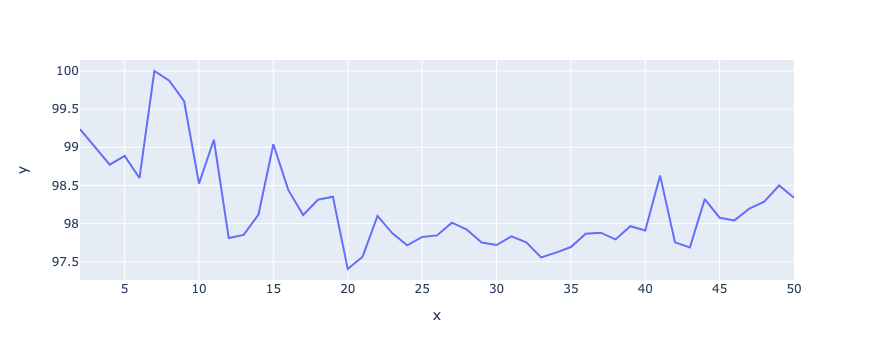

In [75]:
# Plot percent of draws the same for each number of clusters
px.line(x = num_clust_16S, y = pct_same_16S)

In [ ]:
%%time
# Code to return pct of draws that had the same relative cluster assignment for 2 to 62 clusters for n_rep replicates
# NB: This takes a long time to run for a modest number of replicates!!

n_rep = 1
num_clust_18S = np.arange(2, asvs_18S.shape[1] + 1)
pct_same_18S = [pctSame_new(asvs_18S, x, n_rep) for x in num_clust_18S]

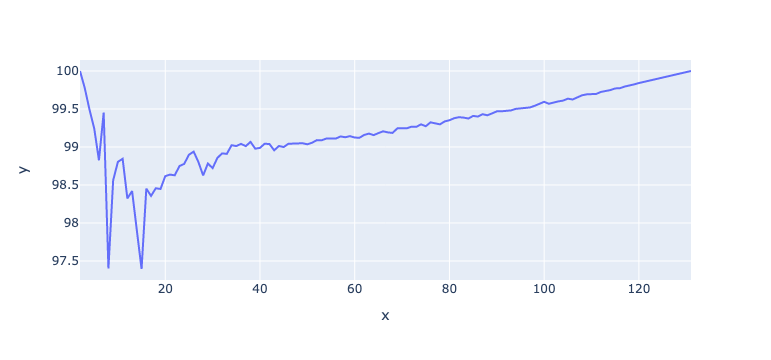

In [35]:
# Plot percent of draws the same for each number of clusters
px.line(x = num_clust_18S, y = pct_same_18S)

In [ ]:
# Plot percent of draws the same for each number of clusters
px.line(x = num_clust_16S, y = pct_same_16S)

# NumPyro

In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

assert numpyro.__version__.startswith("0.11.0")

ModuleNotFoundError: No module named 'numpyro'

In [ ]:
# Need to install numpyro; 

In [88]:
# Prepare training data
dataset_HA2 = df[['pc1_values_16',  'pc2_values_16','pc3_values_16','pc4_values_16','pc5_values_16','pc6_values_16', 'pc1_values_18', 'pc2_values_18'
                         ]]
train = torch.tensor(dataset_HA2.values, dtype=torch.float)
train = dataset_HA2#pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18, pc2_values_18  = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6],  train[:, 7]


In [89]:
def model(pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18_obs=None):
    a = numpyro.sample("PC1_a", dist.Normal(0., 10.))
    b_PC1 = numpyro.sample("PC1_b1", dist.Normal(0., 1.))
    b_PC2 = numpyro.sample("PC1_b2", dist.Normal(0., 1.))
    b_PC3 = numpyro.sample("PC1_b3", dist.Normal(0., 1.))
    b_PC4 = numpyro.sample("PC1_b4", dist.Normal(0., 1.))
    b_PC5 = numpyro.sample("PC1_b5", dist.Normal(0., 1.))
    b_PC6 = numpyro.sample("PC1_b6", dist.Normal(0., 1.))
    sigma = numpyro.sample("PC1_sigma", dist.Uniform(0., 10.))
    
    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16
    with numpyro.plate("data", len(pc6_values_16)):
        return pyro.sample("PC1_obs", dist.Normal(mean, sigma), obs=pc1_values_18_obs)
 

In [90]:
from sklearn.preprocessing import LabelEncoder
pc1_values_18_encoder = LabelEncoder()
train["pc1_values_18"] = pc1_values_18_encoder.fit_transform(dataset_HA2['pc1_values_18'].values)

pc1_values_16 =  dataset_HA2['pc1_values_16'].values
pc2_values_16 =  dataset_HA2['pc2_values_16'].values
pc3_values_16 =  dataset_HA2['pc3_values_16'].values
pc4_values_16 =  dataset_HA2['pc4_values_16'].values
pc5_values_16 =  dataset_HA2['pc5_values_16'].values
pc6_values_16 =  dataset_HA2['pc6_values_16'].values
pc1_values_18 = train["pc1_values_18"].values

In [93]:
%%time
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=2) #this implements num_chains
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,pc1_values_16,  pc2_values_16,pc3_values_16,pc4_values_16, pc5_values_16, pc6_values_16,  pc1_values_18_obs=pc1_values_18)

posterior_samples = mcmc.get_samples()

sample: 100%|█| 3000/3000 [00:01<00:00, 1958.17it/s, 3 steps of size 7.26e-01. a
sample: 100%|█| 3000/3000 [00:00<00:00, 13092.38it/s, 7 steps of size 7.03e-01. 

CPU times: user 1.94 s, sys: 31.1 ms, total: 1.97 s
Wall time: 1.96 s


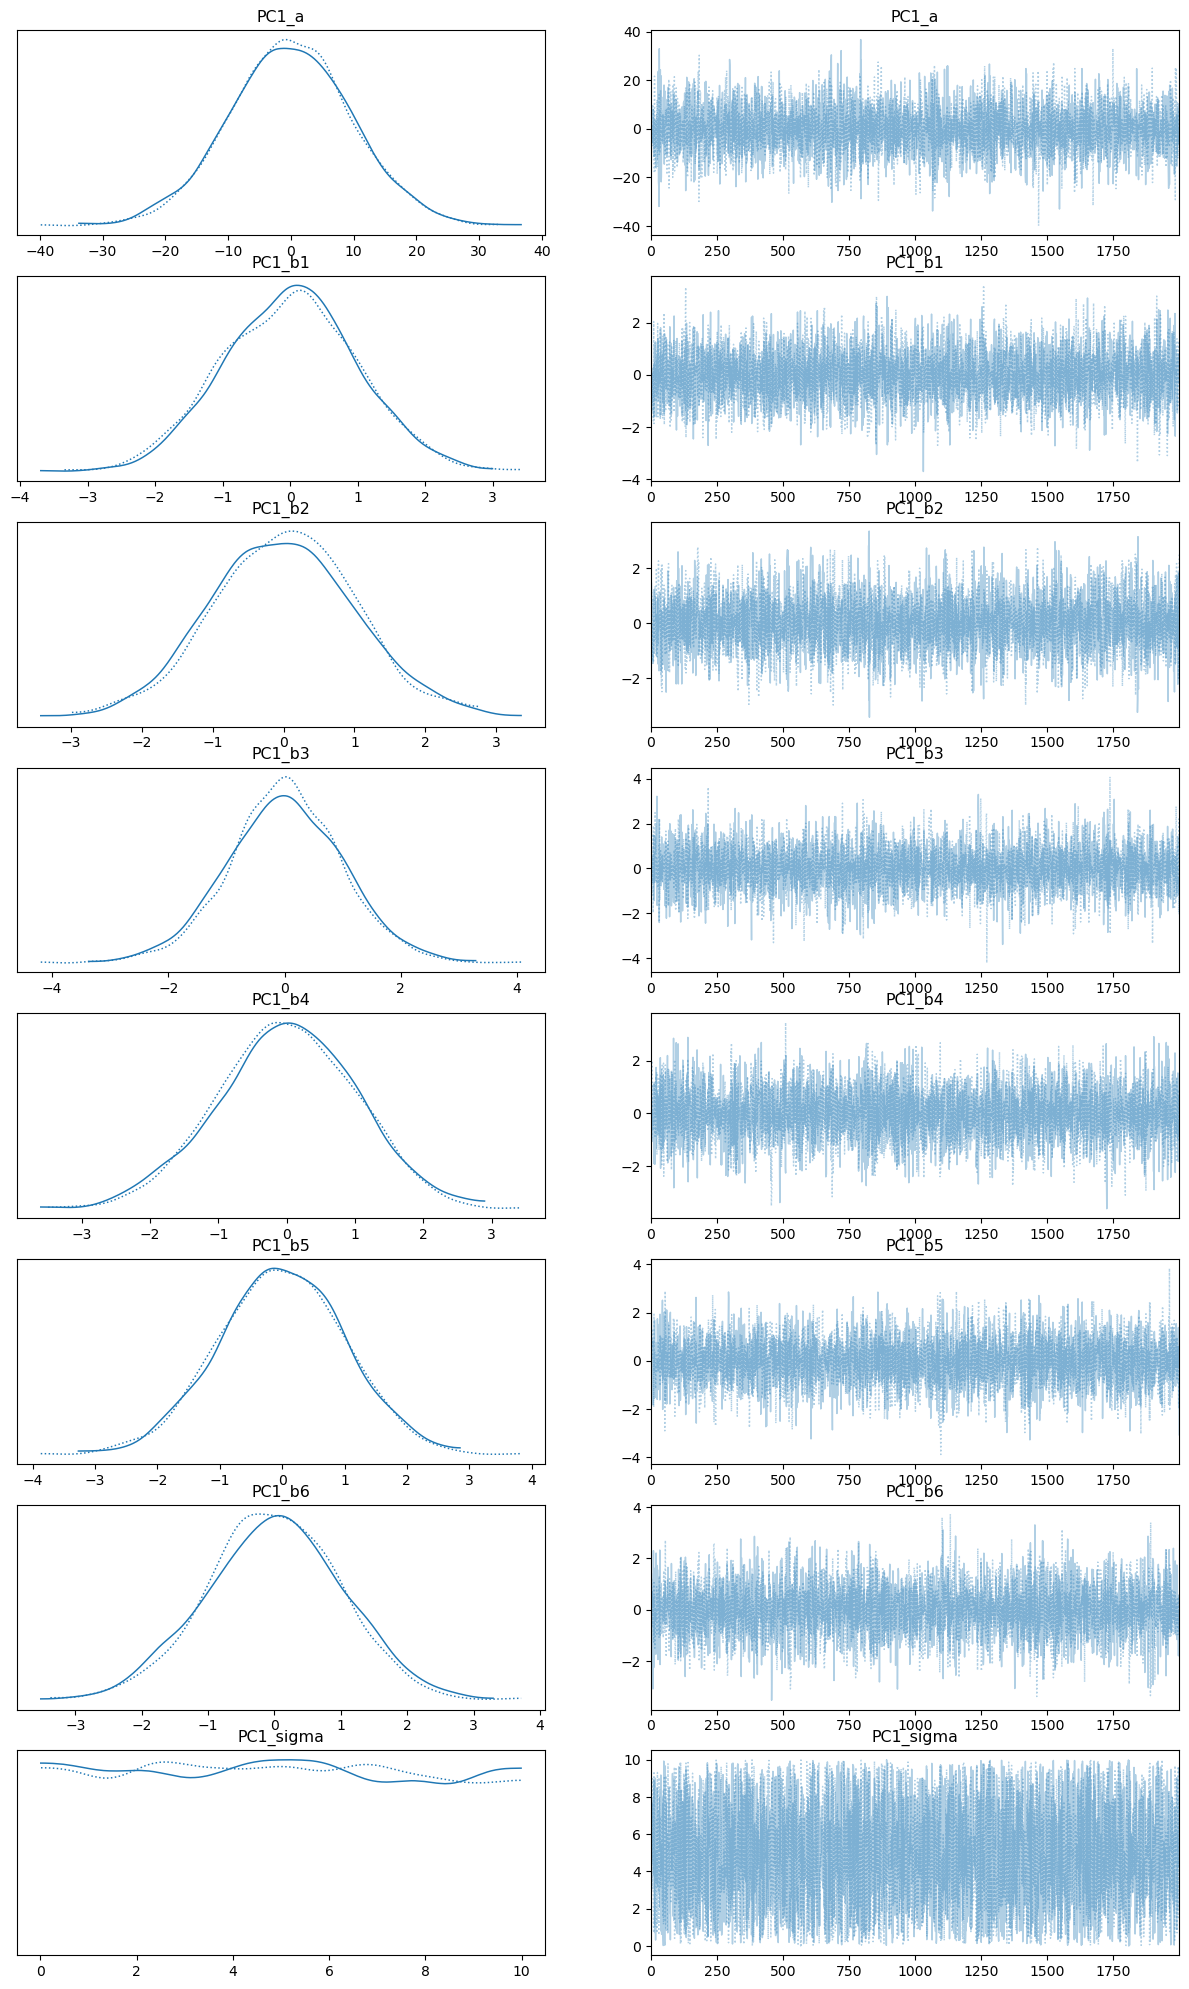

In [94]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));
